# Популярные подходы выявления аномалий

### 1. Одноклассовый метод опорных векторов

Будем строить линейную функцию $a(x) = sign \langle w, x \rangle$, и потребуем,
чтобы она отделяла выборку от начала координат с максимальным отступом.
Соответствующая оптимизационная задача будет иметь следующий вид:

$$
\left\{
        \begin{aligned}
            & \frac{1}{2} \|w\|^2
            +
            \frac{1}{\nu \ell} \sum_{i = 1}^{\ell} \xi_i
            -
            \rho
            \to \min_{w, \xi, \rho} \\
            & \langle w, x_i \rangle
            \geq
            \rho - \xi_i,
            \quad i = 1, \dots, \ell, \\
            & \xi_i \geq 0, \quad i = 1, \dots, \ell.
        \end{aligned}
\right.
$$


Здесь гиперпараметр $\nu$ отвечает за корректность на обучающей выборке -
можно показать, что он является верхней границей на число аномалий (объектов выборки,
на которых $a(x) = -1$).
Решающее правило будет иметь вид

$$
\
    a(x)
    =
    sign\left(
        \langle w, x \rangle
        -
        \rho
    \right),
\
$$
где ответ -1 будет соответствовать выбросу.

### 2. Isolation forest

На этапе обучения будем строить лес, состоящий из N деревьев.
Каждое дерево будем строить стандартным жадным алгоритмом,
но при этом признак и порог будем выбирать случайно.
Строить дерево будем до тех пор, пока в вершине не окажется ровно один объект,
либо пока не будет достигнута максимальная высота.


Метод основан на предположении о том, что чем сильнее объект отличается от большинства,
тем быстрее он будет отделён от основной выборки с помощью случайных разбиений.
Соответственно, выбросами будем считать те объекты, которые оказались на небольшой глубине.

Чтобы вычислить оценку аномальности объекта $x$, найдём расстояние от соответствующего ему листа
до корня в каждом дереве.
Если лист, в котором оказался объект, содержит только его, то в качестве оценки $h_n(x)$
от данного $n$-го дерева будем брать саму глубину $k$;
если же в листе оказалось $m$ объектов, то в качестве оценки возьмём величину $h_n(x) = k + c(m)$.
Здесь $c(m)$ - средняя длина пути от корня до листа в бинарном дереве поиска, которая вычисляется по формуле
$$
\
    c(m)
    =
    2H(m - 1) - 2\frac{m - 1}{m},
\
$$
а $H(i) \approx \ln(i) + 0.5772156649$ - $i$-е гармоническое число.
Оценку аномальности вычислим на основе средней глубины, нормированной на среднюю длину пути в дереве,
построенном на выборке размера $\ell$:
$$
\
    a(x)
    =
    2^{-\frac{
            \frac{1}{N} \sum_{n = 1}^{N} h_n(x)
        }{
            c(\ell)
        }
    }.
\
$$


### 3. Метрический метод LOF (Local Outlier Factor)

Суть метода: измерение локального отклонения плотности конкретной точки данных по отношению к ее соседям. Идея состоит в том, чтобы обнаружить наблюдения, которые имеют значительно меньшую плотность, чем их соседи. Именно эти точки и будут являться аномалиями. 

Ниже приведен алгоритм подсчета метрики LOF.

![jupyter](./LOF.png)

## Сравнение подходов.

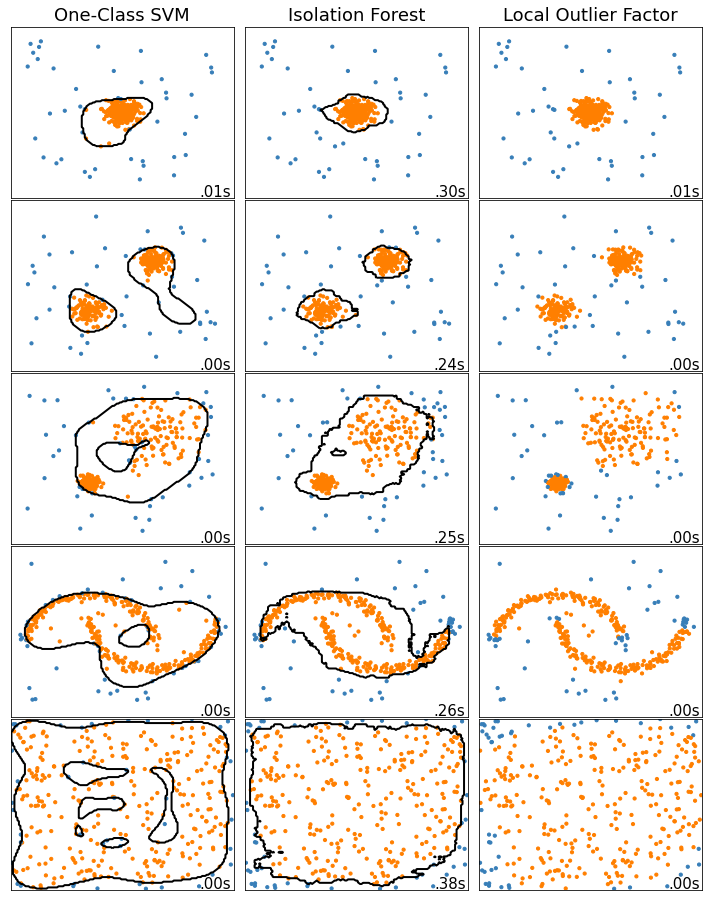

In [23]:
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import sklearn
from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.pipeline import make_pipeline

matplotlib.rcParams["contour.negative_linestyle"] = "solid"

# Example settings
n_samples = 300
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers

# define outlier/anomaly detection methods to be compared.


anomaly_algorithms = [
    
    ("One-Class SVM", OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),

    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
]

# Define datasets
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0
    * (
        make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0]
        - np.array([0.5, 0.25])
    ),
    14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
    # Add outliers
    X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if name == "Local Outlier Factor":
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)

        # plot the levels lines and the points
        if name != "Local Outlier Factor":  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xlim(-7, 7)
        plt.ylim(-7, 7)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

P.S. Подход LOF не показывает границу принятия решения черным цветом, поскольку у него нет метода прогнозирования, который можно было бы применить к новым данным, когда он используется для обнаружения выбросов.